In [118]:
import numpy as np
import pandas as pd 
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

In [2]:
game = pd.read_csv('game_info.csv') 

In [3]:
display(game.head(1))
print (game.shape)

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,...,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,...,West Coast Software||West Coast Software Limited,Adventure||Puzzle,West Coast Software||West Coast Software Limited,Everyone 10+,3,70,0,2,0,0


(345667, 27)


In [4]:
game.isnull().sum()

id                           0
slug                         2
name                         2
metacritic              342428
released                 27201
tba                          0
updated                      0
website                 284812
rating                       0
rating_top                   0
playtime                     0
achievements_count           0
ratings_count                0
suggestions_count            0
game_series_count            0
reviews_count                0
platforms                 3391
developers                6236
genres                   67190
publishers              214606
esrb_rating             290551
added_status_yet             0
added_status_owned           0
added_status_beaten          0
added_status_toplay          0
added_status_dropped         0
added_status_playing         0
dtype: int64

# Cleaning

In [6]:
# Fill missing value 
#for i in range (0,game.shape[0]):
#    if pd.isnull(game['developers'][i]):
#        game['developers'][i] = game['publishers'][i]

In [7]:
# Dropping missing datas more than 80%
game.drop(['id','metacritic','released','esrb_rating',
           'updated','developers','publishers','website'],axis = 1,inplace = True)
# Dropping not meaningful data 
game.drop(['slug'],axis = 1,inplace = True)
# Dropping the game without name
game = game[~game['name'].isnull()].reset_index(drop=True)

In [8]:
# Replace the missing value with unknown instead of Null value 
game['genres'] = game['genres'].fillna('unknown_genre')
game['platforms'] = game['platforms'].fillna('unknown_plat')
#game['developers'] = game['developers'].fillna('unknown')

In [9]:
for i in range (0,len(game.isnull().sum())):
    if game.isnull().sum()[i] == 0:
        continue
    else:
        print('unclean')
print('clean')

clean


In [10]:
#game['updated'] = pd.to_datetime(game['updated'])
genres = game['genres'].str.get_dummies('|')
platforms = game['platforms'].str.get_dummies('|')
game['tba'] = game['tba'].map({False: '0',True:'1'})

In [11]:
game = game.join(genres)
game = game.join(platforms)
game.drop(['genres','platforms'],axis = 1,inplace = True)

In [12]:
game.head(10)

,name,tba,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,...,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,iOS,mac,macOS,unknown_plat
0,D/Generation HD,0,0.0,0,1,80,0,283,0,0,...,0,0,0,0,0,1,0,0,1,0
1,G Prime Into The Rain,0,0.0,0,0,26,0,375,0,0,...,0,0,0,0,0,1,0,0,1,0
2,Land Sliders,0,0.0,0,0,0,1,71,0,1,...,0,0,0,0,0,0,1,0,0,0
3,Pixel Gear,0,0.0,0,0,0,0,443,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gods and Idols,0,0.0,0,1,0,4,268,0,4,...,0,0,0,0,0,0,0,0,0,0
5,Plague venue,0,0.0,0,0,0,0,45,0,0,...,1,0,0,0,0,0,0,0,0,0
6,The Moon Sliver (itch),0,0.0,0,0,0,0,121,0,0,...,0,0,0,0,0,0,0,0,1,0
7,Red Entity,0,0.0,0,0,0,0,33,0,0,...,0,0,0,0,0,0,0,0,1,0
8,Rollman (itch),0,0.0,0,0,0,0,131,0,0,...,0,0,0,0,0,0,0,0,0,0
9,HippiesVsCops,0,0.0,0,0,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#game['rating'].unique()

# EDA

In [15]:
genres_list = list(genres.columns.values.tolist())
genres_counts = []
for i in genres_list:
    count = game[i].value_counts()[1]
    genres_counts.append(count)

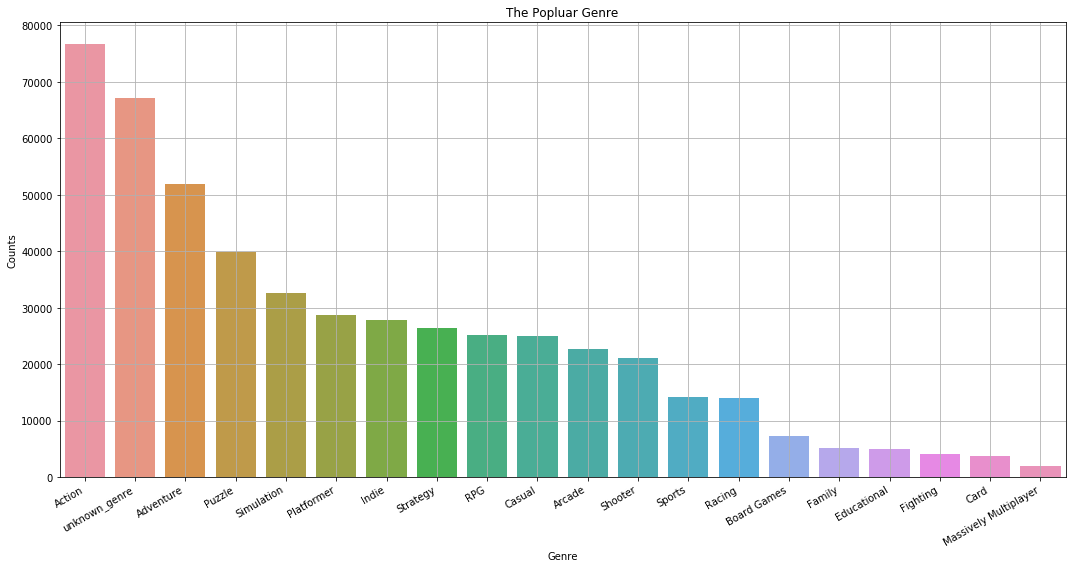

In [16]:
plot1 = pd.DataFrame({'Genre' : genres_list , 'Counts' : genres_counts})
plot1 = plot1.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot1['Genre'], y=plot1['Counts']).set_title("The Popluar Genre")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In [17]:
platforms_list = list(platforms.columns.values.tolist())
platforms_counts = []
for i in platforms_list:
    count = game[i].value_counts()[1]
    platforms_counts.append(count)

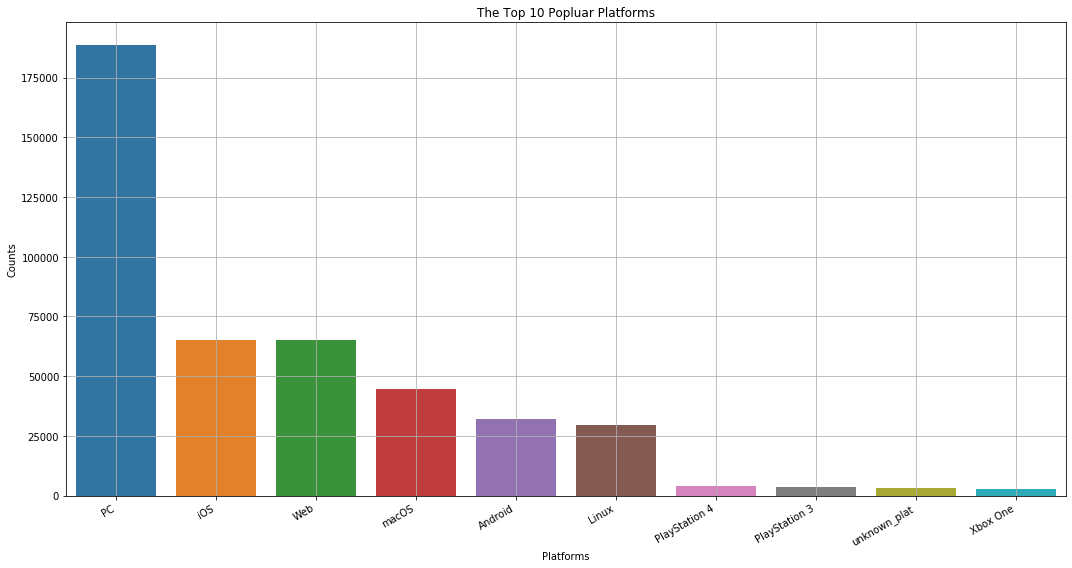

In [18]:
plot2 = pd.DataFrame({'Platforms' : platforms_list , 'Counts' : platforms_counts})
plot2 = plot2.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot2['Platforms'][0:10], y=plot2['Counts'][0:10]).set_title("The Top 10 Popluar Platforms")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

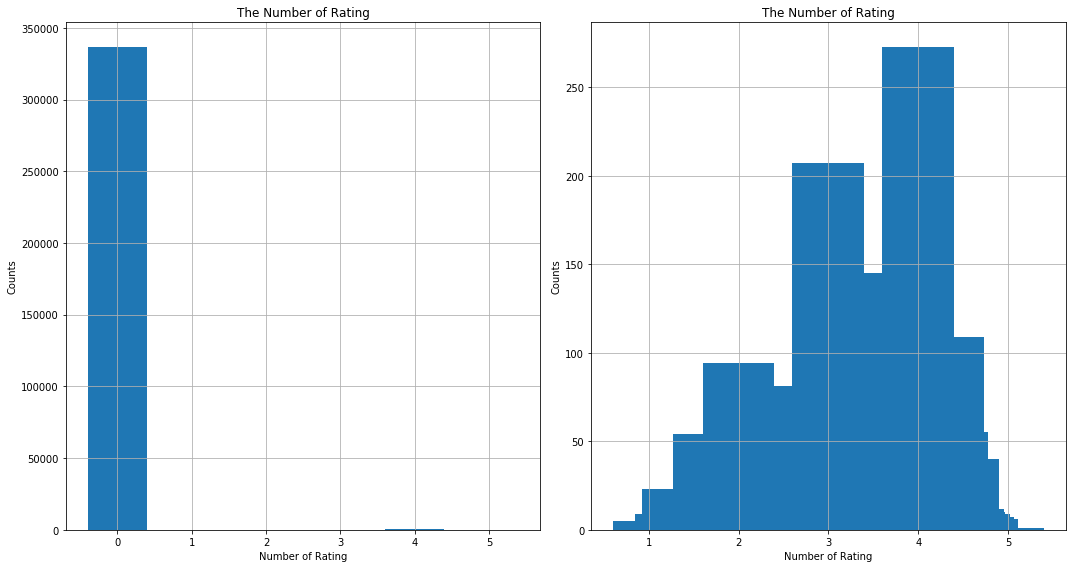

In [94]:
fig, ax = plt.subplots(1,2,figsize = (15,8))

ax[0].bar(game['rating'].value_counts().index, game['rating'].value_counts().values)
ax[1].bar(game['rating'].loc[game['rating'] != 0.0].value_counts().index, 
         game['rating'].loc[game['rating'] != 0.0].value_counts().values)


ax[0].set_title('The Number of Rating')
ax[1].set_title('The Number of Rating')
ax[0].set_xlabel('Number of Rating')
ax[1].set_xlabel('Number of Rating')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
plt.show()

# A User Independent System

In [49]:
top_rated = game.sort_values(by=['rating'], ascending=False)
top_rated['name'].head(10)

291589                                  Star Citizen
168115                                 Disco Elysium
163072               The Witcher 3: Game of the Year
288737                Fatal Frame III: The Tormented
230302                            One Must Fall 2097
309994                  Ace Combat 5: The Unsung War
195805                      Klonoa 2: Lunatea's Veil
306783                             NBA Street Vol. 2
292971    The Witcher 3: Wild Hunt - Hearts of Stone
145112             Advance Wars 2: Black Hole Rising
Name: name, dtype: object

In [50]:
top_rated.head(10).loc[:,['rating','ratings_count']]

,rating,ratings_count
291589,5.00,6
168115,4.86,22
163072,4.74,268
288737,4.71,7
230302,4.71,7
309994,4.71,7
195805,4.71,6
306783,4.71,7
292971,4.71,267
145112,4.70,10


In [58]:
top_rated_v2 = game.sort_values(by=['rating'], ascending=False)

top_rated_v2 = top_rated_v2.loc[top_rated_v2['ratings_count']>1500]

top_rated_v2.loc[:,['name','rating','ratings_count']].head(10)

,name,rating,ratings_count
238383,The Witcher 3: Wild Hunt,4.68,2437
291899,Portal 2,4.61,2323
308907,God of War,4.56,1751
152701,Uncharted 4: A Thief’s End,4.52,1583
185152,Red Dead Redemption 2,4.52,1628
37736,Portal,4.49,1922
37746,Half-Life 2,4.48,1599
250429,Grand Theft Auto V,4.47,2645
307488,The Elder Scrolls V: Skyrim,4.39,1917
152101,DOOM (2016),4.38,1534


# Data Analysis

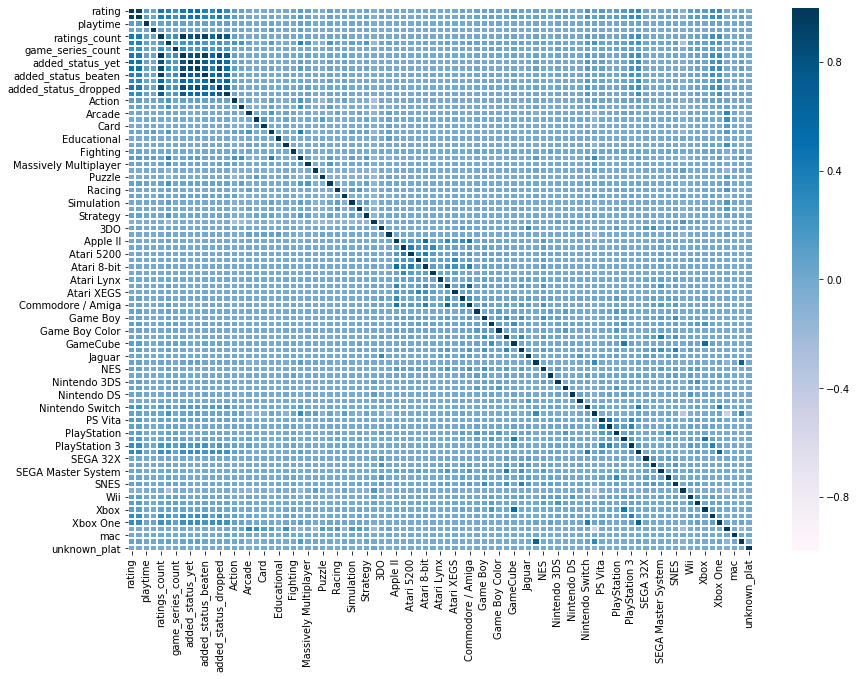

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.heatmap(game.corr(), vmin=-1, vmax=1, cmap="PuBu", linewidths=1)

In [104]:
game.corr()[['rating']].query('rating >= 0.3 or rating <= -0.3').style.background_gradient(cmap=cm)  

,rating
rating,1
rating_top,0.939267
ratings_count,0.423208
suggestions_count,0.352373
reviews_count,0.423345
added_status_yet,0.476698
added_status_owned,0.50184
added_status_beaten,0.358405
added_status_toplay,0.303158
added_status_dropped,0.44057


In [138]:
#'rating_top','ratings_count','suggestions_count','reviews_count',
#     'added_status_yet','added_status_owned','added_status_beaten',
#     'added_status_toplay','added_status_dropped'
X = game[['rating_top','suggestions_count',
     'added_status_yet',
     'added_status_toplay','added_status_dropped']]
y = game['rating']

In [139]:
X_withconst = sm.add_constant(X)
sm.OLS(y, X_withconst).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                 5.366e+05
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:40:29   Log-Likelihood:                 93852.
No. Observations:              345665   AIC:                        -1.877e+05
Df Residuals:                  345659   BIC:                        -1.876e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0037      0.000     -8.817      0.000      -0.005      -0.003
rating_top               0.8009      0.001   1324.262      0.000       0.800       0.802
suggestions_count     6.257e-05   2.84e-06     22.033      0.000     5.7e-05    6.81e-05
added_status_yet         0.0039   8.51e-05     45.522      0.000       0.004       0.004
added_status_toplay      0.0004   6.19e-05      6.077      0.000       0.000       0.000
added_status_dropped     0.0021   6.74e-05     30.598      0.000       0.002       0.002
==============================================================================
Omnibus:                   562190.856   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        760901079.716
Skew:                         -10.570   Prob(JB):                         0.00
Kurtosis:                     231.875   Cond. No.                         307.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
ans = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])], 
              index= X.columns)

In [141]:
ans.sort_values(ascending = False).apply(lambda x: '%.5f' % x)

added_status_yet        2.59062
added_status_dropped    2.24898
rating_top              1.43375
added_status_toplay     1.34979
suggestions_count       1.16642
dtype: object

VIF

        ratings_count           38600.87168
        reviews_count           44.15528
        added_status_owned      10.72255
        
p - value

        added_status_beaten	1.406e-05	2.33e-05	0.603	0.546	-3.16e-05	5.97e-05

In [142]:
X_withconst = sm.add_constant(X)
linear_reg = sm.OLS(y, X_withconst).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                 5.366e+05
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:41:22   Log-Likelihood:                 93852.
No. Observations:              345665   AIC:                        -1.877e+05
Df Residuals:                  345659   BIC:                        -1.876e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0037      0.000     -8.817      0.000      -0.005      -0.003
rating_top               0.8009      0.001   1324.262      0.000       0.800       0.802
suggestions_count     6.257e-05   2.84e-06     22.033      0.000     5.7e-05    6.81e-05
added_status_yet         0.0039   8.51e-05     45.522      0.000       0.004       0.004
added_status_toplay      0.0004   6.19e-05      6.077      0.000       0.000       0.000
added_status_dropped     0.0021   6.74e-05     30.598      0.000       0.002       0.002
==============================================================================
Omnibus:                   562190.856   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        760901079.716
Skew:                         -10.570   Prob(JB):                         0.00
Kurtosis:                     231.875   Cond. No.                         307.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

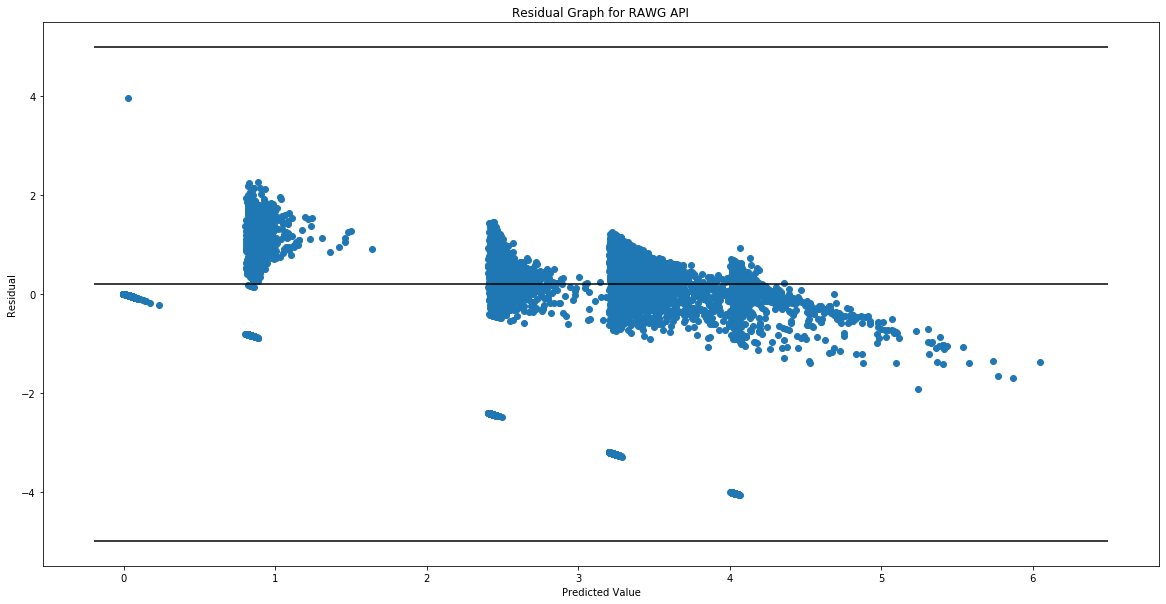

In [156]:
plt.figure(figsize = (20,10))
plt.scatter(linear_reg.fittedvalues,linear_reg.resid)
plt.hlines(y=5, xmin = -0.2 , xmax = 6.5)
plt.hlines(y=0.2, xmin = -0.2 , xmax = 6.5)
plt.hlines(y=-5, xmin = -0.2 , xmax = 6.5)
plt.title('Residual Graph for RAWG API')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.show()